In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import copy
from sklearn.metrics import mean_squared_error

import ase.io
from ase.geometry import wrap_positions
from time import time
import json

from utils.rascaline import RascalineSphericalExpansion
from utils.models.soap import compute_power_spectrum

from utils.models.linear import LinearModel
from utils.models.full_kernel import FullKernelGap
from utils.models.sparse_kernel import SparseKernelGap
from utils.models.sparse_kernel import select_support_points, SparseKernelGap
from utils.pylode import PyLODESphericalExpansion

from rascal.representations import SphericalInvariants
from rascal.models import Kernel, train_gap_model
from rascal.utils import from_dict, to_dict, CURFilter, dump_obj, load_obj, get_score, print_score, FPSFilter

In [4]:
def rmse(actual, predicted):
    a=0
    n=len(actual)
    for i in np.arange(n):
        a+=np.power(actual[i]-predicted[i],2)
    return np.sqrt(a/n)

In [5]:
hypers_lr = {
    'smearing':1.4,
    'max_angular':0,
    'max_radial':10,
    'cutoff_radius':5.,
    'potential_exponent':6,
    'radial_basis': 'gto',
    'compute_gradients':True
}

cutoffList = [4., 4.5, 5., 5.5, 6.] # cutoff, the first dimension
widthList = [1.5, 2., 2.5, 3.] # width, the second dimension
alphaList = np.geomspace(1e-5,1.,10) #alpha, the third dimension

In [6]:
scoreCoordinatesDim1 = np.load('data/scoreCoordinatesDim1.npy')
scoreCoordinatesDim2 = np.load('data/scoreCoordinatesDim2.npy')
scoreCoordinatesDim3 = np.load('data/scoreCoordinatesDim3.npy')
scoreTestEnergy = np.load('data/scoreTestEnergy.npy')
scoreTrainEnergy = np.load('data/scoreTrainEnergy.npy')
scoreTrainForces = np.load('data/scoreTrainForces.npy')

In [7]:
print(scoreCoordinatesDim1)
print(scoreCoordinatesDim2)
print(scoreCoordinatesDim3)

[4.  4.5 5.  5.5 6. ]
[1.5 2.  2.5 3. ]
[1.00000000e-05 3.59381366e-05 1.29154967e-04 4.64158883e-04
 1.66810054e-03 5.99484250e-03 2.15443469e-02 7.74263683e-02
 2.78255940e-01 1.00000000e+00]


In [8]:
print(scoreTestEnergy.min())

for i in np.arange(scoreTestEnergy.shape[0]):
    for j in np.arange(scoreTestEnergy.shape[1]):
        for k in np.arange(scoreTestEnergy.shape[2]):
            if scoreTestEnergy[i,j,k] == scoreTestEnergy.min():
                print(i,j,k)
                print('cutoff: '+str(cutoffList[i]))
                print('width: '+str(widthList[j]))
                print('alpha: '+str(alphaList[k]))



0.022895432946742303
1 0 4
cutoff: 4.5
width: 1.5
alpha: 0.0016681005372000592


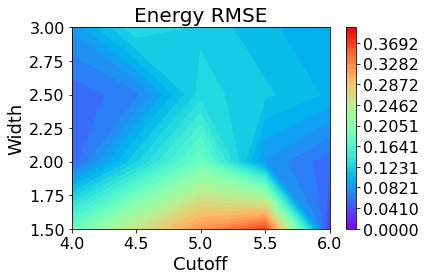

In [9]:
from mpl_toolkits import mplot3d
from matplotlib import cm

X = cutoffList
Y = widthList
X, Y = np.meshgrid(X,Y)
Z = scoreTestEnergy[:,:,4].reshape(X.shape)

fig, ax = plt.subplots()
levels = np.linspace(0,0.4,40)
cb = ax.contourf(X, Y, Z,levels=levels, cmap = 'rainbow')
colorBar = fig.colorbar(cb)
ax.set_title('Energy RMSE',fontsize=20)
ax.set_xlabel('Cutoff',fontsize=18)
ax.set_ylabel('Width',fontsize=18)
colorBar.ax.tick_params(labelsize=16)
ax.tick_params(labelsize=16)
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.tight_layout()

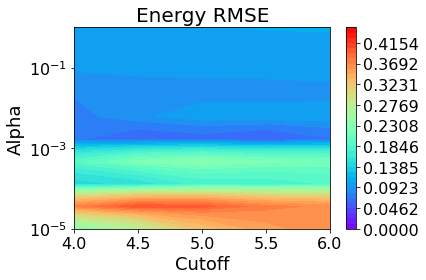

In [10]:
from mpl_toolkits import mplot3d
from matplotlib import cm

X = cutoffList
Y = alphaList
X, Y = np.meshgrid(X,Y)
Z = scoreTestEnergy[:,3,:].reshape(X.shape)

fig, ax = plt.subplots()
levels = np.linspace(0, 0.45, 40)
cb = ax.contourf(X, Y, Z, levels=levels,cmap = 'rainbow')
colorBar = fig.colorbar(cb)
ax.set_title('Energy RMSE',fontsize=20)
ax.set_xlabel('Cutoff',fontsize=18)
ax.set_ylabel('Alpha',fontsize=18)
#ax.set_xscale('log')
ax.set_yscale('log')
colorBar.ax.tick_params(labelsize=16)
ax.tick_params(labelsize=16)
plt.tight_layout()

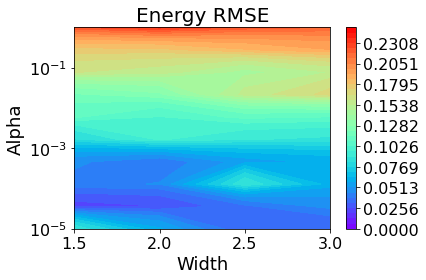

In [11]:
from mpl_toolkits import mplot3d
from matplotlib import cm

X = widthList
Y = alphaList
X, Y = np.meshgrid(X,Y)
Z = scoreTestEnergy[1,:,:].reshape(X.shape)

fig, ax = plt.subplots()
levels = np.linspace(0, 0.25, 40)
cb = ax.contourf(X, Y, Z, levels=levels,cmap = 'rainbow')
colorBar = fig.colorbar(cb)
ax.set_title('Energy RMSE',fontsize=20)
ax.set_xlabel('Width',fontsize=18)
ax.set_ylabel('Alpha',fontsize=18)
#ax.set_xscale('log')
ax.set_yscale('log')
colorBar.ax.tick_params(labelsize=16)
ax.tick_params(labelsize=16)
plt.tight_layout()